In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import pickle as pk
import gensim
from nltk.util import ngrams
from collections import Counter
import collections.abc
collections.Mapping = collections.abc.Mapping
import shifterator as sh
import matplotlib.pyplot as plt
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta


data_dir = "./data/"

In [2]:
MONTHS = ['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
         '2016-10', '2016-11', '2016-12']

## preprocessing

In [6]:
import re
import html
import sys
from unicodedata import category
punctuation_chars =  [chr(i) for i in range(sys.maxunicode) 
                             if category(chr(i)).startswith("P")]

punctuation_chars = ''.join(punctuation_chars)
def preprocess(text):
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    
    # remove relational link such as:  [contact the moderators of this subreddit](/message/compose/?to=/r/Buddhism) 
    opening_braces = '\(\/'
    closing_braces = '\)'
    non_greedy_wildcard = '.*?'
    text = re.sub(f'[{opening_braces}]{non_greedy_wildcard}[{closing_braces}]', '', text)
    
    # remove linked text such as "[^Exclude ^me]"
    opening_braces = '\[\^'
    closing_braces = '\]'
    non_greedy_wildcard = '.*?'
    text = re.sub(f'[{opening_braces}]{non_greedy_wildcard}[{closing_braces}]', '', text)
    
    # remove Bot message e.g. "^HelperBot ^v1.1 ^/r/HelperBot_ ^I ^am ^a ^bot. ^Please ^message ^/u/swim1929 ^with ^any ^feedback ^and/or ^hate. ^Counter: ^144517"
    text = re.sub(f'[\^]({non_greedy_wildcard})($|\s)', '', text)

    # remove punctuations
    text = text.translate(str.maketrans("", "", punctuation_chars+"><=^|$+~`"))
    text = re.sub("\n", " ", text)
    return text

import string
def count_ngrams(input_texts, n=1):
    ngrams_counter = Counter()
    for text in input_texts:
        text = preprocess(text)
        text_ngrams = ngrams(word_tokenize(text), n)
        ngrams_counter.update(text_ngrams)
    return ngrams_counter   

def get_ngrams_counter(subreddit):
    usecols=['year-month', 'timestamp', 'text', 'speaker']
    comments_df = pk.load(open(data_dir + f"{subreddit}-comments.pk", "rb"))
    comments_df = comments_df[usecols]
    comments_df['year'] = comments_df['year-month'].apply(lambda s: int(s.split("-")[0]))
    comments_df = comments_df[comments_df['year'] >= 2016]

    ngrams_counter = dict()

    start_month = '2016-01'
    last_month = '2018-10'
    m = start_month
    while m <= last_month:
        print("\t", m)
        monthly_comments = comments_df[comments_df['year-month'] == m]['text'].tolist()
        ngrams_counter[m] = count_ngrams(monthly_comments)

        m = (parse(m) + relativedelta(months=1)).strftime("%Y-%m")
    return ngrams_counter

In [7]:
subreddit_ngrams_counter = dict()
for subreddit in ['Judaism', 'Buddhism', 'Christianity']:
    print(subreddit)
    subreddit_ngrams_counter[subreddit] = get_ngrams_counter(subreddit)

Judaism
	 2016-01
	 2016-02
	 2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
	 2017-01
	 2017-02
	 2017-03
	 2017-04
	 2017-05
	 2017-06
	 2017-07
	 2017-08
	 2017-09
	 2017-10
	 2017-11
	 2017-12
	 2018-01
	 2018-02
	 2018-03
	 2018-04
	 2018-05
	 2018-06
	 2018-07
	 2018-08
	 2018-09
	 2018-10
Buddhism
	 2016-01
	 2016-02
	 2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
	 2017-01
	 2017-02
	 2017-03
	 2017-04
	 2017-05
	 2017-06
	 2017-07
	 2017-08
	 2017-09
	 2017-10
	 2017-11
	 2017-12
	 2018-01
	 2018-02
	 2018-03
	 2018-04
	 2018-05
	 2018-06
	 2018-07
	 2018-08
	 2018-09
	 2018-10
Christianity
	 2016-01
	 2016-02
	 2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
	 2017-01
	 2017-02
	 2017-03
	 2017-04
	 2017-05
	 2017-06
	 2017-07
	 2017-08
	 2017-09
	 2017-10
	 2017-11
	 2017-12
	 2018-01
	 2018-02
	 2018-03
	 2018-04
	 2018-05


In [8]:
pk.dump(subreddit_ngrams_counter, open(data_dir + "subreddit_ngrams_counter.pk", "wb"))

## JSD

In [ ]:
import metrics

In [ ]:
subreddit_ngrams_counter = pk.load(open(data_dir + "subreddit_ngrams_counter.pk", "rb"))

In [126]:
subreddit_jsd_diffs = dict()
for subreddit in ['Judaism', 'Buddhism', 'Christianity']:
    print(subreddit)
    last_month = '2018-10'
    jsd_diffs = dict()
    for month_1 in MONTHS:
        print("\t", month_1)
        jsd_diffs[month_1] = dict()
        month_2 = (parse(month_1) + relativedelta(months=1)).strftime("%Y-%m")
        while month_2 <= last_month:
            my_jsd = metrics.JSD(subreddit_ngrams_counter[subreddit][month_1], 
                               subreddit_ngrams_counter[subreddit][month_2],   
                               weight_1 = 0.5, weight_2 = 0.5, 
                               base=2)
        
            jsd_diffs[month_1][month_2] = my_jsd.total_diff
            month_2 = (parse(month_2) + relativedelta(months=1)).strftime("%Y-%m")
    subreddit_jsd_diffs[subreddit] = jsd_diffs

Judaism
	 2016-01
	 2016-02
	 2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
Buddhism
	 2016-01
	 2016-02
	 2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
Christianity
	 2016-01
	 2016-02
	 2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12


In [176]:
subreddit = 'Judaism'
jsd_diffs = subreddit_jsd_diffs[subreddit]
jsd_df = pd.DataFrame.from_dict(jsd_diffs, orient='index').T
ranked = jsd_df.rank(axis=1)

data = list()
ranked_1y = dict()
ranked_3m = dict()
for m in MONTHS:
    ranked_1y[m] = (ranked[m].dropna()[:12].mean())
    ranked_3m[m] = (ranked[m].dropna()[:3].mean())
avg_ranks = pd.concat((pd.Series(ranked_1y), pd.Series(ranked_3m), ranked.mean()), axis=1)
avg_ranks.columns = ['1 year', '3 months', 'EOD']


Text(0.02, 0.5, 'test month')

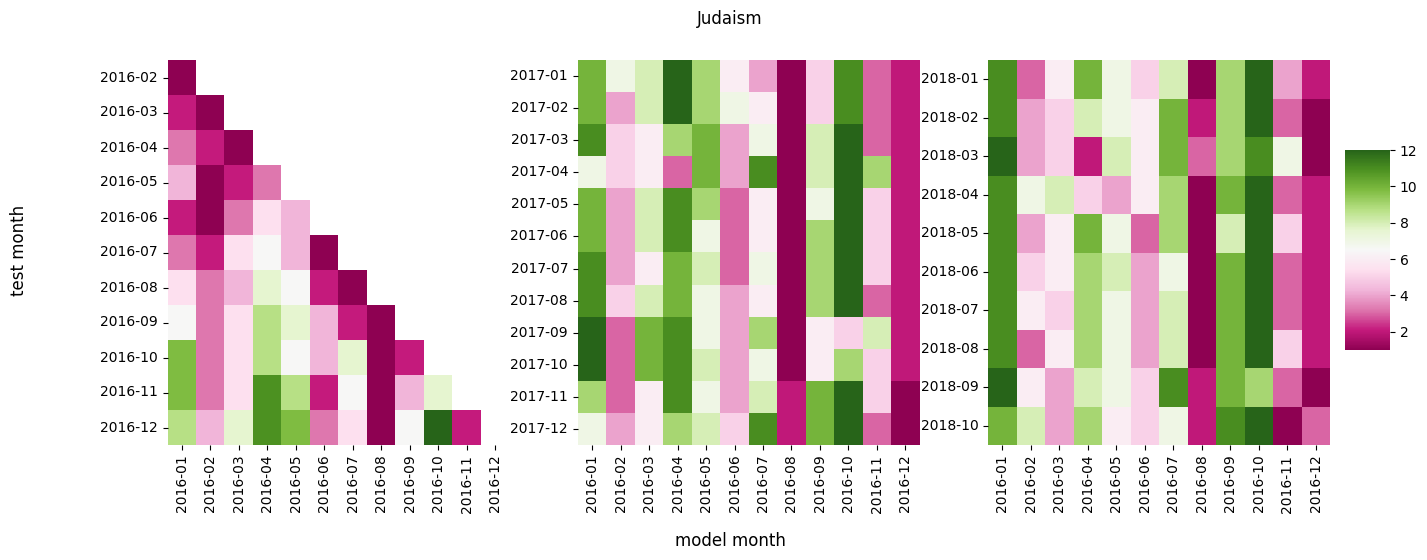

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.heatmap(ax = axes[0], data = ranked.iloc[:11], cmap="PiYG", cbar=False)
sns.heatmap(ax = axes[1], data = ranked.iloc[11:23], cmap="PiYG", cbar=False)
sns.heatmap(ax = axes[2], data = ranked.iloc[23:],cmap="PiYG", cbar_ax= cbar_ax)
fig.suptitle(subreddit)
fig.supxlabel('model month', y = -0.1)
fig.supylabel("test month")

Text(0.5, 0, 'test month')

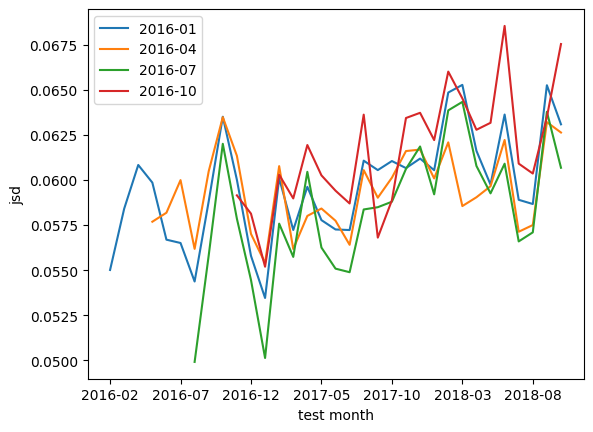

In [607]:
jsd_df.iloc[:, ::3].plot()
plt.ylabel("jsd")
plt.xlabel("test month")

In [ ]:
print(avg_ranks.sort_values("1 year").to_markdown())

In [434]:
print(avg_ranks.sort_values("3 months").to_markdown())

|         |   1 year |   3 months |      EOD |
|:--------|---------:|-----------:|---------:|
| 2016-08 |  1       |    1       |  1.26923 |
| 2016-02 |  2.83333 |    1.33333 |  3.875   |
| 2016-01 |  5.16667 |    2       |  8.57576 |
| 2016-03 |  4.91667 |    2       |  5.87097 |
| 2016-12 |  1.83333 |    2       |  1.81818 |
| 2016-06 |  3.58333 |    2.33333 |  4.10714 |
| 2016-11 |  4.66667 |    2.66667 |  4.17391 |
| 2016-07 |  5.66667 |    3.33333 |  7.25926 |
| 2016-09 |  6.5     |    4       |  8       |
| 2016-04 |  7.75    |    4.66667 |  8.53333 |
| 2016-05 |  7.58333 |    4.66667 |  7.27586 |
| 2016-10 | 10.5     |    9.66667 | 11.0833  |


## JSD word contribution

In [192]:
import importlib
importlib.reload(metrics)

<module 'metrics' from '/Users/wyw/Projects/religion-subreddits/metrics.py'>

In [186]:
subreddit = 'Christianity'
df = pd.DataFrame()
for i in range(len(MONTHS)):
    month_1 = MONTHS[i]
    print(month_1)
    for j in range(i+1, len(MONTHS)):
        month_2 = MONTHS[j]
        print("\t", month_2)
        my_jsd = metrics.JSD(subreddit_ngrams_counter[subreddit][month_1], 
                               subreddit_ngrams_counter[subreddit][month_2],   
                               weight_1 = 0.5, weight_2 = 0.5, 
                               base=2)
        contrib = pd.DataFrame.from_dict(my_jsd.item_contribution, orient='index')
        contrib = contrib.sort_values("contribution", ascending=False)[:20]
        contrib['month'] = contrib['from_distribution'].apply(lambda d: month_1 if d == "1" else month_2)
        contrib = contrib.drop("from_distribution", axis=1)
        contrib = contrib.reset_index().rename({"level_0": "item"}, axis=1)
        contrib['comparison'] = f"{month_1} / {month_2}"
        df = pd.concat((df, contrib))
df.to_csv(data_dir + f"/output/jsd_contrib_{subreddit}.csv", index=False)



2016-01
	 2016-02
	 2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
2016-02
	 2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
2016-03
	 2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
2016-04
	 2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
2016-05
	 2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
2016-06
	 2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
2016-07
	 2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
2016-08
	 2016-09
	 2016-10
	 2016-11
	 2016-12
2016-09
	 2016-10
	 2016-11
	 2016-12
2016-10
	 2016-11
	 2016-12
2016-11
	 2016-12
2016-12


In [187]:
with pd.ExcelWriter(data_dir + 'output/word_contribution.xlsx') as writer:  
    df1.to_excel(writer, sheet_name='Sheet_name_1')
    df2.to_excel(writer, sheet_name='Sheet_name_2')
    
    for subreddit in ['Judaism', 'Buddhism', 'Christianity']:
        df = pd.read_csv(data_dir + f"/output/jsd_contrib_{subreddit}.csv")
        output = df.groupby(["comparison", 'month'])['item'].apply(lambda x: ", ".join(x))
        output.to_excel(writer, sheet_name = subreddit)
        
        

In [179]:
import shifterator

In [228]:
subreddit='Judaism'
month_1 = "2016-04"
month_2 = "2016-02"
sh_jsd = shifterator.JSDivergenceShift(type2freq_1=subreddit_ngrams_counter[subreddit][month_1],
                                 type2freq_2=subreddit_ngrams_counter[subreddit][month_2],
                                 weight_1=0.3,
                                 weight_2=0.7,
                                 base=2,
                                 alpha=1)

/usr/local/lib/python3.10/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


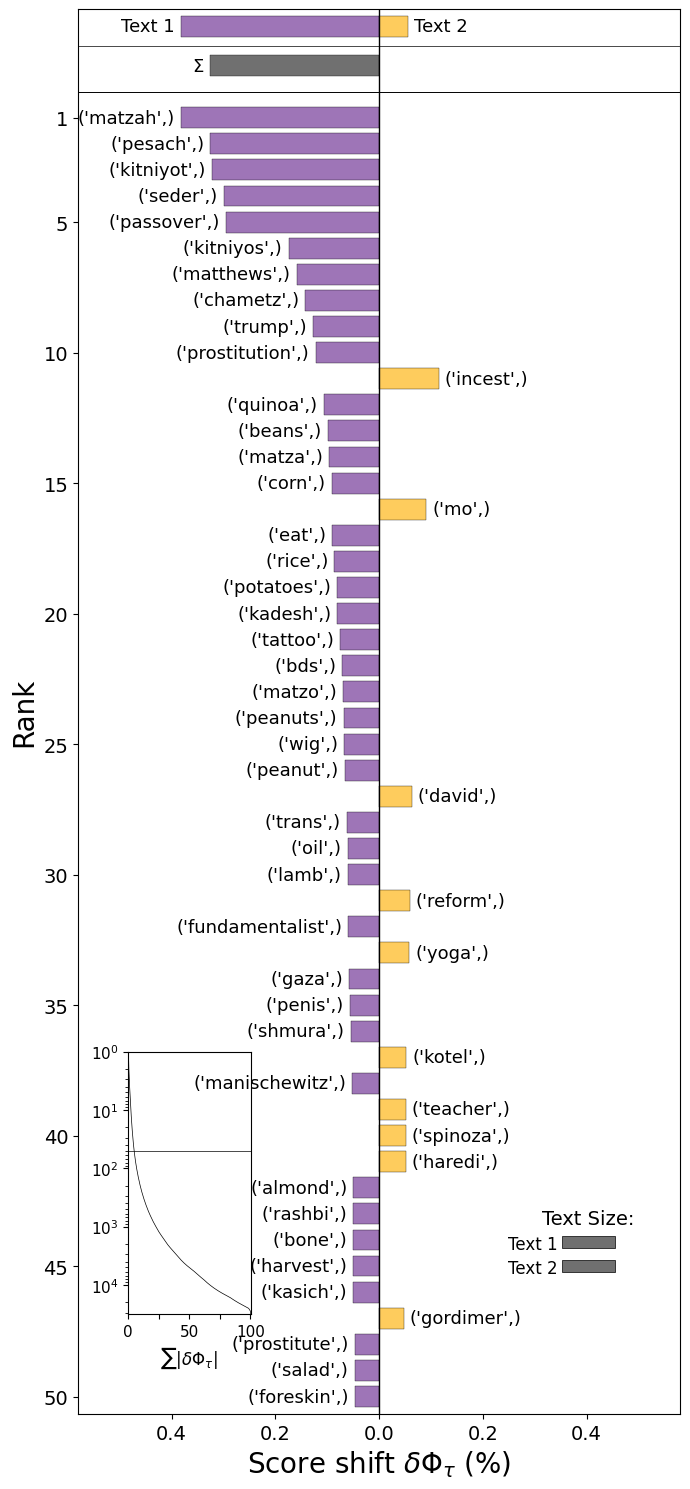

<AxesSubplot: xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [229]:
sh_jsd.get_shift_graph()

In [225]:
sh_jsd = shifterator.JSDivergenceShift(type2freq_1=subreddit_ngrams_counter[subreddit][month_1],
                                 type2freq_2=subreddit_ngrams_counter[subreddit][month_2],
                                 weight_1=0.5,
                                 weight_2=0.5,
                                 base=2,
                                 alpha=1)

/usr/local/lib/python3.10/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


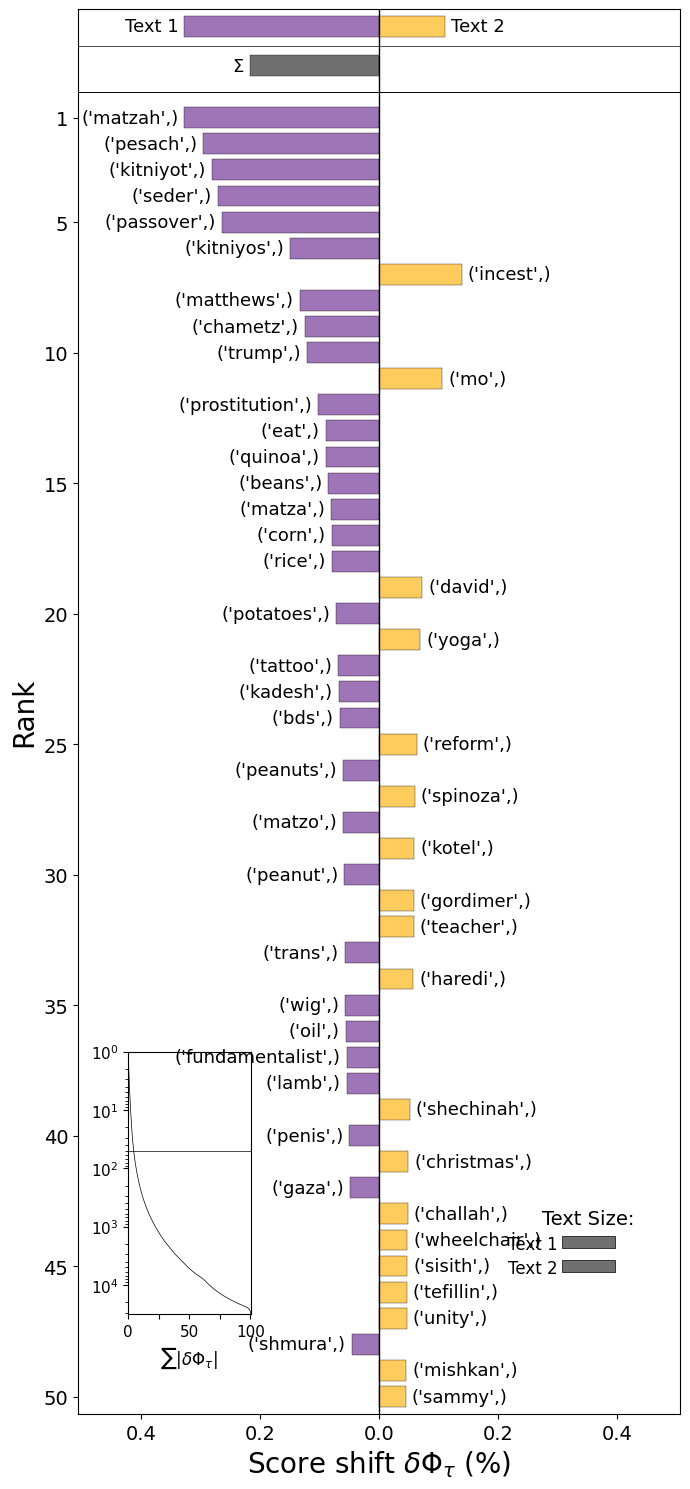

<AxesSubplot: xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [227]:
sh_jsd.get_shift_graph()